# Import

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
df = pd.read_csv('../data/cleaned_data/master.csv',index_col=0)
df.head()

,nonglu_price,hommali_price,agri_prod_index,crops_prod_index,paddy_prod_index,nonglu_prod_index,hommali_prod_index,agri_price_index,crops_price_index,paddy_price_index,...,water_station_M7,water_station_N1,water_station_N67,water_station_Ny1B,water_station_P1,water_station_P17,water_station_S4B,water_station_Sw5A,water_station_Y17,water_station_Y1C
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,6696.0,7628.0,109.703894,114.011647,43.580672,72.649707,8.077559,110.377654,113.821771,100.581118,...,140.50,66.17,520.00,26.85,38.96,679.63,6.23,97.92,1.24,20.25
2006-02-01,6633.0,7873.0,93.049409,91.755084,46.062229,85.832560,0.000000,111.337228,115.390439,101.563145,...,87.75,39.02,501.32,26.22,64.11,573.91,4.69,69.55,0.00,13.07
2006-03-01,6649.0,7960.0,92.803780,87.828340,74.516499,138.854375,0.000000,112.498075,117.876876,103.063764,...,108.95,20.94,558.72,42.23,68.26,523.38,2.23,60.02,2.32,35.51
2006-04-01,6880.0,8028.0,75.452369,67.662286,66.215260,123.385807,0.000000,115.595159,121.878356,104.906097,...,188.40,45.73,692.79,61.08,84.68,508.65,0.06,76.80,5.84,31.54
2006-05-01,6782.0,8069.0,77.366260,68.992476,35.785484,66.682829,0.000000,113.408937,119.725058,104.687875,...,270.30,94.19,1027.25,44.98,146.19,1092.68,34.64,88.76,168.17,268.37


In [4]:
# Set index as datetime
df.index = pd.to_datetime(df.index,format="%Y-%m-%d")

In [5]:
# Check type of value
df.dtypes.value_counts()

float64    49
Name: count, dtype: int64

In [6]:
df.columns

Index(['nonglu_price', 'hommali_price', 'agri_prod_index', 'crops_prod_index',
       'paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index',
       'agri_price_index', 'crops_price_index', 'paddy_price_index',
       'nonglu_price_index', 'hommali_price_index', 'agri_export_value',
       'rice_export_value', 'ricet_export_amount', 'cpi', 'cpi_rice',
       'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
       'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4',
       'fertilizer_5', 'fertilizer_6', 'water_station_B10',
       'water_station_C13', 'water_station_C2', 'water_station_G8',
       'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
       'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
       'water_station_M6A', 'water_station_M7', 'water_station_N1',
       'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
       'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
       'water_

# Stationarity Check

In [8]:
result = adfuller(df['nonglu_price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -3.302824716654775
p-value: 0.014752680770463844
Critical Values:
   1%: -3.4604283689894815
   5%: -2.874768966942149
   10%: -2.57382076446281


In [9]:
# ADF Statistic = -3.303
# A highly negative value generally indicates evidence against the null hypothesis 
# (non-stationarity). However, the magnitude alone is not the only determinant; 
# the test's critical values must also be considered for confirmation.

# More negative than both the 5% (-2.875) and 10% (-2.574) critical values
# But not more negative than the 1% critical value (-3.460)
# This means one can reject the null hypothesis of non-stationarity at the 5% confidence level 
# (which we're using down below) but not at the 1% level (which is basically fine here)
# The p-value of 0.015 confirms this, as it's less than 0.05 but greater than 0.01

# p-value = 0.015
# This is less than the standard 0.05 significance level
# Therefore, we reject the null hypothesis of non-stationarity
# This output justifies rejecting the null hypothesis that the series is non-stationary.

# Model

In [11]:
# Create the differenced target
y = df['nonglu_price'].diff().dropna()

# Define independent variables (predictors) list
xvars = ['hommali_price', 'agri_prod_index', 'crops_prod_index',
        'paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index',
       'agri_price_index', 'crops_price_index', 'paddy_price_index', 'agri_export_value',
       'rice_export_value', 'ricet_export_amount', 'cpi', 'cpi_rice',
       'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
       'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4',
       'fertilizer_5', 'fertilizer_6','water_station_B10',
       'water_station_C13', 'water_station_C2', 'water_station_G8',
       'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
       'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
       'water_station_M6A', 'water_station_M7', 'water_station_N1',
       'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
       'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
       'water_station_Y17', 'water_station_Y1C']

# Adjust X to match the same periods
# Remove the first row to match diff_data
X = df[xvars].iloc[1:]

# Split data into training and test sets
# shuffle=False maintains time order (crucial for time series!)
# test_size=20 reserves last 20 observations for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=20)

## Model 1

In [13]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
model_1 = ARIMA(
    y_train,           # Dependent variable (nonglu_price)
    exog=X_train,      # External variables 
    order=(2, 1, 2),   # ARIMA parameters: (p=2, d=1, q=2)
    freq = 'MS'        # Monthly data
).fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [14]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  205
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1471.706
Date:                Fri, 13 Dec 2024   AIC                           3045.413
Time:                        11:45:31   BIC                           3214.637
Sample:                    02-01-2006   HQIC                          3113.867
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
hommali_price          -0.4226      0.094     -4.508      0.000      -0.606      -0.239
agri_prod_index        -6.5789     20.571     -0.320      0.749     -46.898      33.740
crops_prod_index        5.9577     14.893      0.400      0.689     -23.232      35.147
paddy_prod_index        2.3785      4.835      0.492      0.623      -7.097      11.854
nonglu_prod_index      -1.8181      2.901     -0.627      0.531      -7.504       3.868
hommali_prod_index     -0.9383      1.769     -0.530      0.596      -4.405       2.529
agri_price_index      -10.5856     46.591     -0.227      0.820    -101.902      80.731
crops_price_index      19.4579     34.507      0.564      0.573     -48.176      87.091
paddy_price_index      80.1687     10.117      7.924      0.000      60.340      99.997
agri_export_value      -0.0275      0.251     -0.110      0.913      -0.519       0.464
rice_export_value      -4.9086      1.214     -4.043      0.000      -7.288      -2.529
ricet_export_amount     0.0024      0.001      4.305      0.000       0.001       0.004
cpi                   -55.8945    133.418     -0.419      0.675    -317.389     205.600
cpi_rice              -42.6909     25.893     -1.649      0.099     -93.440       8.059
pol_rate              211.8686    236.652      0.895      0.371    -251.961     675.698
neer                  -76.5966    149.994     -0.511      0.610    -370.579     217.386
reer                   71.9195    153.866      0.467      0.640    -229.653     373.492
sirikit_water           0.8689      0.540      1.609      0.108      -0.189       1.927
bhumibol_water         -0.3446      0.208     -1.656      0.098      -0.752       0.063
fertilizer_1            0.0902      0.101      0.892      0.372      -0.108       0.288
fertilizer_2           -0.0745      0.084     -0.892      0.372      -0.238       0.089
fertilizer_3           -0.3159      0.103     -3.060      0.002      -0.518      -0.114
fertilizer_4            0.0256      0.074      0.348      0.728      -0.119       0.170
fertilizer_5            0.0703      0.113      0.623      0.533      -0.151       0.292
fertilizer_6            0.1694      0.077      2.201      0.028       0.019       0.320
water_station_B10       1.1617      1.283      0.906      0.365      -1.352       3.676
water_station_C13       0.0265      0.124      0.214      0.831      -0.217       0.270
water_station_C2       -0.0244      0.181     -0.135      0.893      -0.378       0.330
water_station_G8        0.1880      1.685      0.112      0.911      -3.114       3.490
water_station_K10       0.0552      0.255      0.216      0.829      -0.445       0.556
water_station_K11A      0.1323      0.228      0.581      0.561      -0.314       0.579
water_station_Kgt3     -0.2108      0.277     -0.761      0.447      -0.754       0.332
water_station_Kh103    -3.1619      2.539     -1.245      0.213      -8.139       1.815
water_station_Kh58A     0.6609      0.667      0.991      0.322      -0.6

In [15]:
# Generate predictions on the test set
preds_1 = model_1.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [16]:
# Evaluate the model_1
model_1_mse = mean_squared_error(y_test, preds_1)
model_1_mse

1617299.1014717766

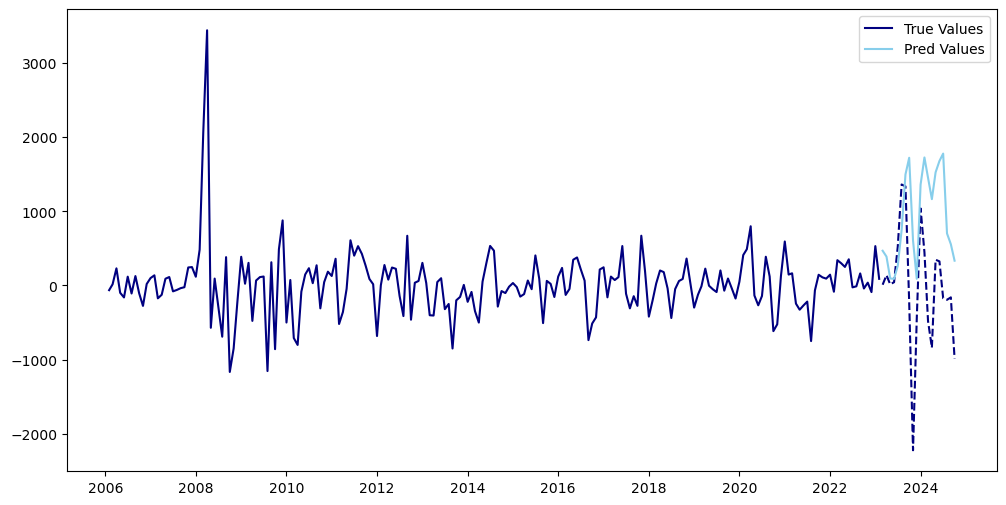

In [17]:
# Plot 
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed')
plt.plot(preds_1, c='skyblue', label='Pred Values')
plt.legend()
plt.show()

## Model 3

In [32]:
# Define the range of p, d, q values to search
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

# Prepare a list of all combinations
param_combinations = list(itertools.product(p_values, d_values, q_values))

# Store results
best_aic = float("inf")
best_params = None
results = []

# Iterate through parameter combinations
for params in param_combinations:
    try:
        model = ARIMA(y_train, exog=X_train, order=params, freq='MS').fit()
        preds_2 = model_2.predict(start=X_test.index[0], end=X_test.index[-1],exog=X_test)
        aic = model.aic
        results.append((params, mse))
        if aic < best_aic:
            best_aic = aic
            best_params = params
    except Exception as e:
        continue  # Some combinations might not be valid

# Display the best parameters
print(f"Best Parameters: {best_params}, AIC: {best_aic}")

# Create a DataFrame of results for inspection
results_df = pd.DataFrame(results, columns=["Parameters", "AIC"])

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

Best Parameters: (0, 0, 1), AIC: 3027.89925516527


In [40]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
model_2 = ARIMA(
    y_train,           # Dependent variable (nonglu_price)
    exog=X_train,      # External variables 
    order=(0, 0, 1),   # ARIMA parameters: (p=0, d=0, q=1)
    freq = 'MS'        # Monthly data
).fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
# Generate predictions on the test set
preds_2 = model_2.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [42]:
# Evaluate the model_2
model_2_mse = mean_squared_error(y_test, preds_2)
model_2_mse

1032761.9991434964

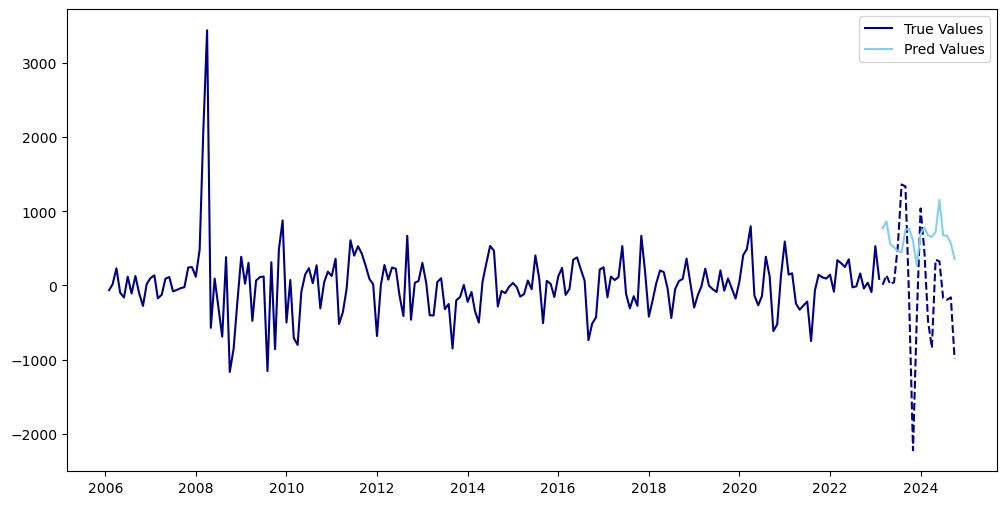

In [43]:
# Plot 
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed')
plt.plot(preds_2, c='skyblue', label='Pred Values')
plt.legend()
plt.show()

## Model 2